In [1]:
import sys
import os

# # Simple approach: add the parent directory to Python path
# project_root = os.path.dirname(os.getcwd())
# sys.path.insert(0, project_root)
# print(f"Added {project_root} to Python path")
# print(f"Current working directory: {os.getcwd()}")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_filling_0p5_t_4_em4_random_basis_mesh_60_gpu_scaling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(1.4626461642547328e-06)

In [4]:
np.max(final_e_difference)

np.float64(9.995396760276165e-09)

### Phase Analysis

In [5]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [6]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [7]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [8]:
threshold = 1E-6

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
gs_m = np.zeros(u_mesh.shape)
gs_n = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((4))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        gs_n[i,j] = c6_diff
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        # else:
        #     rs_recording[3] = 1
        gs_m[i,j] = np.max(np.abs(magnetism_arr))
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                m_recording[1] = 1
            else:
                net_m = np.sum(magnetism_arr)
                if np.abs(net_m) <= magnetism_arr.size * threshold:
                    m_recording[3] = 1
                else:
                    m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

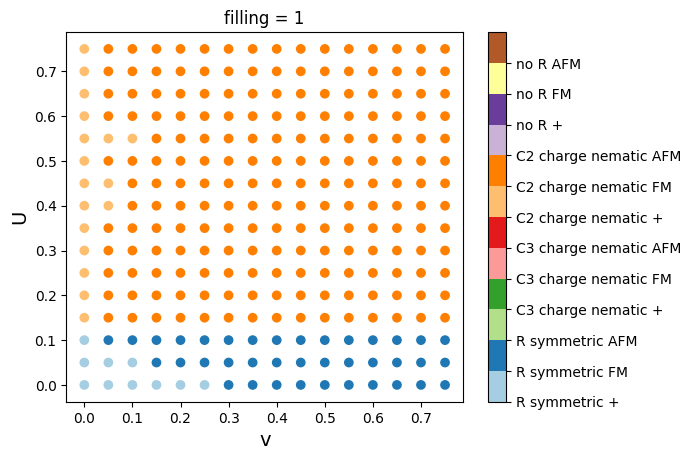

In [9]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(u_mesh, v1_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [10]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

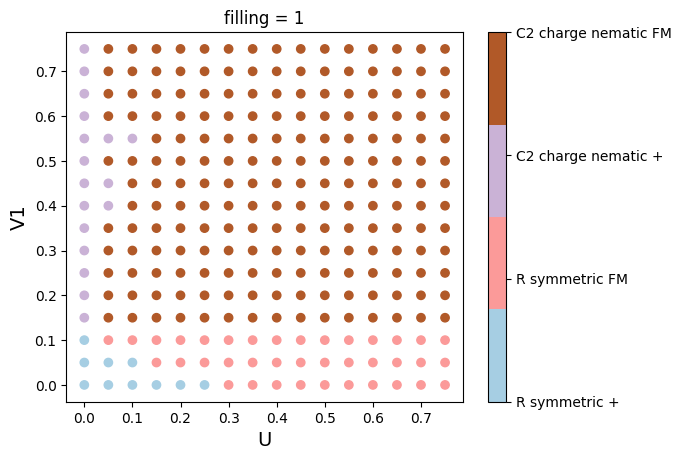

In [11]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(u_mesh, v1_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('U', size = '14')
plt.ylabel('V1', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

Text(0.5, 1.0, 'filling = 1')

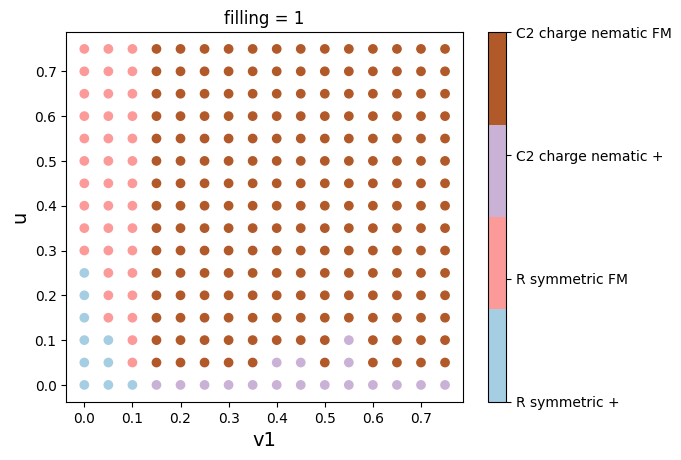

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

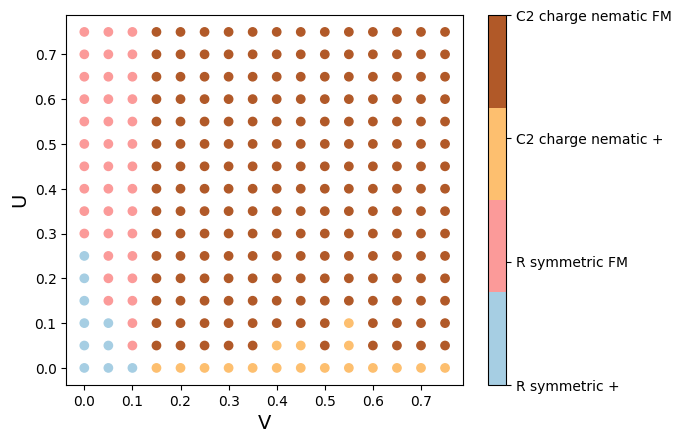

In [13]:
from matplotlib.colors import ListedColormap

paired = plt.get_cmap("Paired").colors
corlor_index = [0,4,6,11]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)

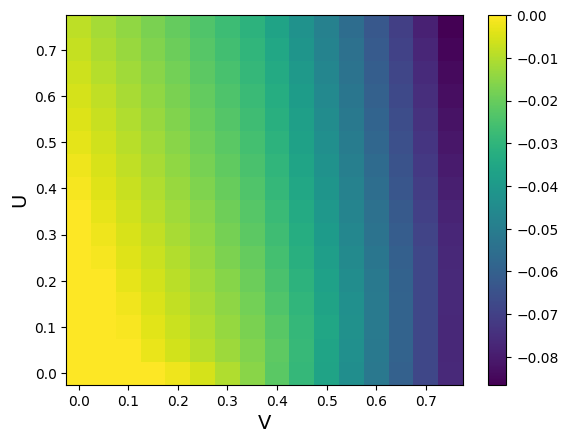

In [14]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

Text(0.5, 1.0, 'ground state c_6_diff')

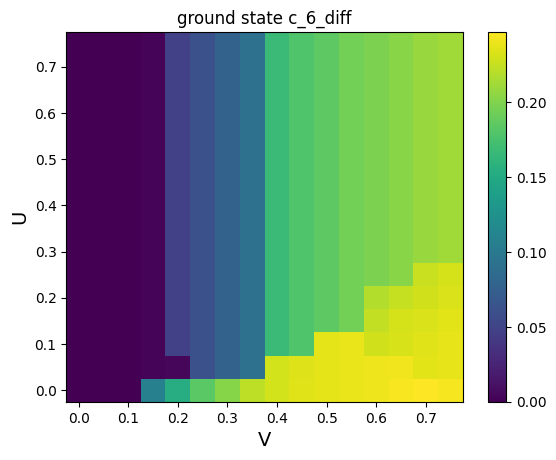

In [15]:
plt.pcolormesh(v1_mesh,u_mesh,gs_n)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state c_6_diff')

Text(0.5, 1.0, 'ground state max magnetization')

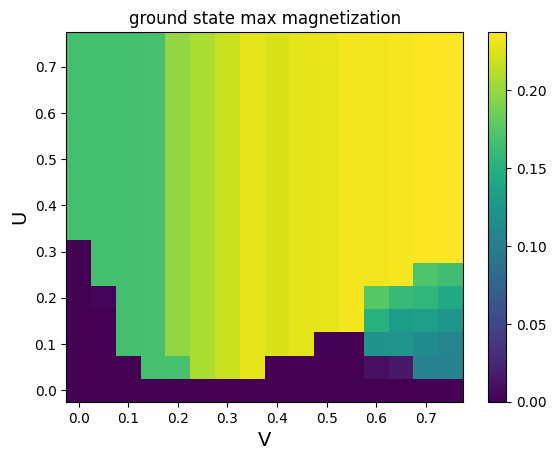

In [16]:
plt.pcolormesh(v1_mesh,u_mesh,gs_m)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

In [17]:
sorted_density[5,5,5]

array([[2.07490517e-01-6.98128535e-26j, 1.46254908e-01-1.17874982e-20j,
        1.46254574e-01-8.68586060e-20j],
       [8.75651076e-27-3.09446761e-51j, 8.75651076e-27-8.10010834e-45j,
        8.75651076e-27+1.37384874e-45j]])

In [18]:
sorted_ground_state_e[5,5]

array([-0.01343191, -0.0134319 , -0.0134319 , -0.0134319 , -0.0134319 ,
       -0.0134319 , -0.01298483, -0.00439475, -0.00439475, -0.00439475])

In [19]:
sorted_ground_state_e[4,5]

array([-0.01239024, -0.01239024, -0.01239024, -0.01239024, -0.01239024,
       -0.01239024, -0.01194316, -0.00465028, -0.00465028, -0.00465028])

In [20]:
sorted_density[4,5,0]

array([[1.46254540e-01-1.45904817e-25j, 1.46254916e-01+7.23572133e-20j,
        2.07490545e-01+2.50226090e-20j],
       [8.75651076e-27-1.19271606e-48j, 8.75651076e-27+3.90435541e-45j,
        8.75651076e-27-4.80587204e-45j]])

In [21]:
sorted_density[4,5,6]

array([[1.66666666e-01-1.18291112e-24j, 1.66666666e-01-7.69455653e-21j,
        1.66666666e-01+5.59571656e-20j],
       [8.75651076e-27-1.13701472e-48j, 8.75651076e-27-6.69091682e-45j,
        8.75651076e-27+5.26726391e-45j]])

In [22]:
sorted_ground_state_e_index[4,5]

array([5, 4, 8, 6, 7, 9, 0, 3, 1, 2])

In [23]:
final_bond[4,5,2]

array([[[[[-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j]],

         [[-0.        +0.00000000e+00j,  0.02973108+1.46587349e-17j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.08220526+1.89269707e-17j,
           -0.        +0.00000000e+00j]]],


        [[[-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           -0.        +0.00000000e+00j]],

  

In [24]:
final_bond[4,5,4]

array([[[[[-0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
           -0.00000000e+00+0.00000000e+00j,
           -0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j]],

         [[-0.00000000e+00+0.00000000e+00j,
            1.17123109e-01+2.98831682e-17j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
           -0.00000000e+00+0.00000000e+00j,
           -0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00+0.00000000e+00j,
            8.34033469e-02+2.70836669e-17j,
            0.00000000e+00+0.00000000e+00j]]],


        [[[-0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [ 0.00000000e+00-0.00000000e+00j,
           -0.00000

In [25]:
la.norm(np.abs(final_bond[4,5,4] - final_bond[4,5,2])) 

np.float64(0.4572741133310711)

In [26]:
sorted_density[6,5,0]

array([[2.07490545e-01+2.73701491e-26j, 1.46254534e-01+7.09097355e-20j,
        1.46254922e-01-9.92307925e-20j],
       [8.75651076e-27+7.25727678e-51j, 8.75651076e-27+5.81145897e-45j,
        8.75651076e-27-4.08351332e-45j]])

In [27]:
sorted_ground_state_e[-2,-1]

array([-0.08545868, -0.08545868, -0.08545868, -0.08545868, -0.08545868,
       -0.08545868, -0.0697079 , -0.0697079 , -0.0697079 , -0.03010314])

In [28]:
sorted_density[-2,-1,0]

array([[2.37246046e-01-4.09191442e-26j, 2.37246314e-01-5.26333301e-20j,
        2.55076394e-02+2.31820355e-21j],
       [8.75651076e-27-1.69645918e-48j, 8.75651076e-27+3.82404570e-45j,
        8.75651076e-27-1.83077607e-45j]])

In [29]:
sorted_density[-2,-1,6]

array([[0.00261902+1.21800478e-27j, 0.12368975+1.32947148e-20j,
        0.12369122+9.99430628e-20j],
       [0.00261902+1.21800478e-27j, 0.12368975+1.32947148e-20j,
        0.12369122+9.99430628e-20j]])

In [30]:
np.mean(final_iteration)

np.float64(46.66171875)

In [31]:
np.max(final_iteration)

np.int32(500)

In [32]:
np.min(final_iteration)

np.int32(2)

### Test the degeneracy of energy